# Assignment 1

## Load the packages

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import os

## Load the Data

In [127]:
train_data = np.load('/content/train_data.npy')
train_label = np.load('/content/train_label.npy')
test_data = np.load('/content/test_data.npy')
test_label = np.load('/content/test_label.npy')

### 1. Normalize the Train Data to have it in range (-1, 1)
- Flatten -> normalize -> reshape
- Note: Using the min and max value from the train_data for the normalization of the test_data

In [128]:
flattened_train_data = train_data.flatten()
flattened_test_data = test_data.flatten()

normalized_train_data = np.interp(flattened_train_data, (np.min(flattened_train_data), np.max(flattened_train_data)), (-1, 1))
normalized_test_data = np.interp(flattened_test_data, (np.min(flattened_train_data), np.max(flattened_train_data)), (-1, 1))

train_data = normalized_train_data.reshape(train_data.shape)
test_data = normalized_test_data.reshape(test_data.shape)

## Create an Activation Class
- ReLU activation function
- Leaky ReLU activation function

In [129]:
class Activation(object):

    # ReLU activation function
    def _ReLU(self, x):
        return np.maximum(x, 0)

    def _ReLU_deriv(self, a):
        # For simplicity, derivative at a=0 is 0 <- very rare event
        return np.where(a > 0, 1, 0)

    # Leaky ReLU activation function - Adjust alpha (0.1)
    def _LeakyReLU(self, x, alpha=0.1):
        return np.maximum(x, alpha*x)

    def _LeakyReLU_deriv(self, a, alpha=0.1):
        # For simplicity, derivative at a=0 is 0 <- very rare event
        return np.where(a > 0, 1, alpha)

    # ------------------------------------------ Implement SoftMAX - the last activation function of a neural network to normalize the output and give probabilities

    # ------------------------------------------ Implement GELU

    def __init__(self, activation='relu'):
        if activation == 'relu':
            self.f = self._ReLU
            self.f_deriv = self._ReLU_deriv
        elif activation == 'leakyrelu':
            self.f = self._LeakyReLU
            self.f_deriv = self._LeakyReLU_deriv
        else:
            quit()

## Create a Hidden Layer

In [130]:
class HiddenLayer(object):

    def __init__(self, n_in, n_out, activation_last_layer='relu', activation='relu', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f

        # activation derivative of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)

        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

    # Forward Pass
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b # input * weight + bias
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output

    # Backpropagation
    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) # input * delta
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input) # delta = delta*weight * derivative_activation
        return delta

## The MLP model

In [131]:
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'relu','relu']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used.
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        # 2 layers: 1 hidden layer. 3 layers: 2 hidden layers....
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # ------------------------------------------------------------------------------- Add SoftMax and Cross Entropy Loss, Change 2 methods below
    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y - y_hat
        loss = 0.5 * error**2
        # calculate the MSE's delta of the output layer
        # Pre-compute the gradient of previous layer's activation func.
        delta = -error * activation_deriv(y_hat)
        # return loss and delta
        return loss, delta

    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # ------------------------------------------------ Here last layer output we need to do Softmax, then cross-entropy loss
    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)

        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])

                # forward pass
                y_hat = self.forward(X[i])

                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output

## Learning

In [132]:
nn = MLP([128, 80, 40 ,1], [None,'relu', 'relu', 'relu'])

# Smaller data for the sake of testing and complexity
input_data = train_data[0:5000,:]
output_data = train_label[0:5000,:]
print(input_data.shape)
print(output_data.shape)

(5000, 128)
(5000, 1)


# Testing - This part is for fun - model is terrible!

In [133]:
### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.001, epochs=500)
print('loss:%f'%MSE[-1])

<ipython-input-131-4e94ea2b463d>:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:0.094030


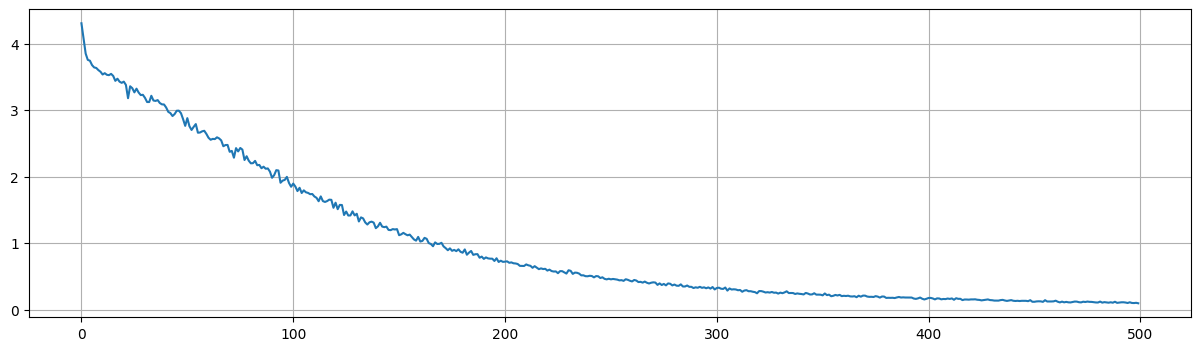

In [134]:
plt.figure(figsize=(15,4))
plt.plot(MSE)
plt.grid()

<ipython-input-131-4e94ea2b463d>:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = self.forward(x[i,:])


Streaming output truncated to the last 5000 lines.
7.324762669350306 and [8]
2.76955683181704 and [0]
4.586725751002154 and [6]
7.78284583007692 and [6]
0.8494846107321932 and [1]
2.979880992420058 and [6]
1.9306191757881135 and [3]
0.07720989125111055 and [1]
3.364211622993022 and [0]
9.610295499006918 and [9]
4.865684325071509 and [5]
7.02585010042601 and [7]
1.2955706778151659 and [9]
7.473136984011739 and [8]
0.6741944412616634 and [5]
0.0 and [7]
0.0 and [8]
4.23905637041823 and [6]
4.41186487127019 and [7]
0.0 and [0]
0.0 and [4]
7.846446592069798 and [9]
0.10771845042376449 and [5]
0.12498583453572998 and [2]
3.05619092935295 and [4]
1.6351389514497816 and [0]
4.700071400730035 and [9]
4.365873706264031 and [6]
4.223768679181733 and [6]
0.0 and [5]
6.589006261627172 and [4]
3.209726187037422 and [5]
4.048141868482235 and [9]
1.868621072048761 and [2]
3.654844520972424 and [4]
11.181622243083856 and [1]
3.7356480691476337 and [9]
5.8934366823315 and [5]
5.354105019502947 and [4]


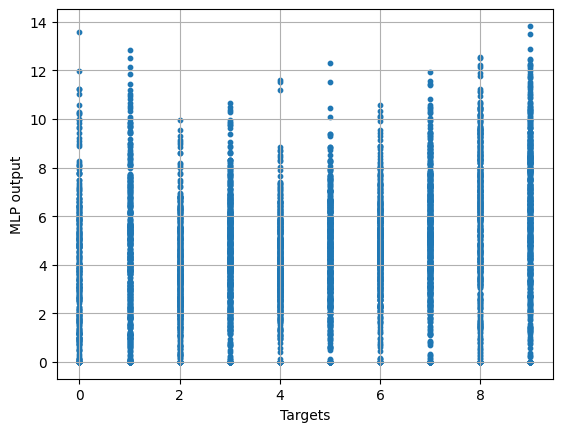

In [135]:
output = nn.predict(test_data[0:5000,:])
plt.scatter(test_label[0:5000,:], output, s=10)
plt.xlabel('Targets')
plt.ylabel('MLP output')
plt.grid()
correct = 0
incorrect = 0
for i in range(5000):
  print(str(output[i]) + " and " + str(test_label[i]))
  if output[i] == test_label[i]:
    correct+=1
  else:
    incorrect+=1
print(correct)
print(incorrect)